# Macro and Micro Bull Market Support Bands
> Can these bull market support bands show support/resistance?

- toc: false
- badges: false
- comments: true
- categories: [Blockchain]
- image: images/chart-preview.png

In [1]:
#hide
#@title 1. PRESS THE PLAY BUTTON ON THE LEFT (PACKAGES)
%%capture
import pandas as pd
import numpy as np
from scipy import stats, signal
import plotly.express as px
import plotly.graph_objects as go
import requests
import datetime

import numpy as np
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgb, to_rgba
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
import random
sns.set()
!pip install mplfinance
# More Plotting libaries 
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num
from dateutil.relativedelta import relativedelta

epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0
    
import time
!pip install yfinance
import yfinance as yf

In [2]:
#@title Data and Plot
#hide
def price_data(tick,p=140,d='Yahoo',t='1d'):
  """
  You can change these Intervals: 
  Currently set to
   - YAHOO: Interval is 1 day 
   - KUCOIN: Interval is 1 day
   - BINANCE: Interval is 1 hour 

  """

  if (d=='Yahoo'):
    ticker = yf.Ticker(tick)
    df = ticker.history(period=f'{p}d',interval='1d')
    cp = df.Close[len(df)-1]
  
  elif (d=='Kucoin'):
    link = f'https://openapi-v2.kucoin.com/api/v1/market/candles?type=1day&symbol={tick}'
    r = requests.get(link)	
    df = pd.DataFrame.from_records(r.json()['data'])
    df.columns = ['Time', 'Open', 'Close', 'High', 'Low', 'Volume', 'Turnover']
    df['Time'] = pd.to_datetime(df['Time'], unit='s', errors='coerce')
    df = df.set_index('Time')
    df = df.head(p) 
    for col in df.columns:
      df[col] = pd.to_numeric(df[col])
    cp = df.Close[0]

  elif (d=='Binance'): 
    url = 'https://api.binance.com/api/v3/klines'
    params = {
      'symbol': tick,
      'interval': t,
      'startTime' : round(unix_time_millis(datetime.datetime.now() - datetime.timedelta(minutes=p*24*60))) #200 hours ago
    }
    r = requests.get(url, params=params)
    results = r.json()
    df = pd.DataFrame.from_records(results)
    df.columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','Ignore.']
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms', errors='coerce')
    df = df.set_index('Open time')
    for col in df.columns:
      df[col] = pd.to_numeric(df[col])
    cp = df.Close[-1]
  elif (d=='Binance1h'): 
    url = 'https://api.binance.com/api/v3/klines'
    params = {
      'symbol': tick,
      'interval': '1h',
      'startTime' : round(unix_time_millis(datetime.datetime.now() - datetime.timedelta(minutes=4800))) #200 hours ago
    }
    r = requests.get(url, params=params)
    results = r.json()
    df = pd.DataFrame.from_records(results)
    df.columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','Ignore.']
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms', errors='coerce')
    df = df.set_index('Open time')
    for col in df.columns:
      df[col] = pd.to_numeric(df[col])
    cp = df.Close[-1]

  return df, cp



def bullMarketSupport(data,cp, tick):
  max52 = max(data.High)
  min52 = min(data.Low)
  df = data.reset_index()
  max30 = max(df.tail(30)['High'])
  min30 = min(df.tail(30)['Low'])
  max140 = max(df.tail(140)['High'])
  min140 = min(df.tail(140)['Low'])

  data = data.dropna()
  sns.set_style("whitegrid")
  f, ax1  = plt.subplots(1, 1,figsize=(20,5), dpi= 150, 
                               facecolor='w', edgecolor='k')

  n = 3
  mpl.rcParams['axes.prop_cycle'] = plt.cycler("color", sns.color_palette("Set2"))

  ohlc = []
  for date, row in data.iterrows():
    openp, highp, lowp, closep = row[:4]
    ohlc.append([date2num(date), openp, highp, lowp, closep])

  data["EMA12"] = data['Close'].ewm(span=12).mean()
  data["EMA26"] = data['Close'].ewm(span=26).mean()
  if (data["EMA12"][-1]>data["EMA26"][-1]):
    print(f'The MICRO support band shows {tick} is BULLISH')
    if (data["EMA12"][-1] > cp > data["EMA26"][-1]): print(f'{tick} is testing MICRO the support: {round(data["EMA26"][-1],2)}')
    elif (data["EMA12"][-1] < cp): print(f'{tick} is {round(100*(cp-data["EMA12"][-1])/data["EMA12"][-1],2)}% ABOVE the MICRO support: {round(data["EMA12"][-1],2)}')
    # elif (data["EMA12"][-1] > cp): print(f'{tick} did not hold support: {round(data["EMA12"][-1],2)}')
  elif (data["EMA12"][-1]< data["EMA26"][-1]):
    print(f'The MICRO support band shows {tick} is BEARISH')
    if (data["EMA12"][-1] < cp < data["EMA26"][-1]): print(f'{tick} is testing MICRO the support: {round(data["EMA12"][-1],2)}')
    elif (data["EMA26"][-1] > cp): print(f'{tick} is {round(-100*(cp-data["EMA26"][-1])/data["EMA26"][-1],2)}% BELOW the MICRO support: {round(data["EMA26"][-1],2)}')
  ax1.fill_between(data.index, data["EMA12"], data["EMA26"], where=(data["EMA12"]>data["EMA26"]), color= '#d8f3dc', alpha = 0.4)
  ax1.fill_between(data.index, data["EMA12"], data["EMA26"], where=(data["EMA12"]<data["EMA26"]), color= '#dc2f02', alpha = 0.2)

  data["SMA140"] = data['Close'].rolling(window=140,min_periods=1).mean()
  data["EMA140"] = data['Close'].ewm(span=140,adjust = False).mean()
  if (data["EMA140"][-1]>data["SMA140"][-1]):
    print(f'The MACRO support band shows {tick} is BULLISH')
    if (data["EMA140"][-1] > cp > data["SMA140"][-1]): print(f'{tick} is testing MACRO the support: {round(data["SMA140"][-1],2)}')
    elif (data["EMA140"][-1] < cp): print(f'{tick} is {round(100*(cp-data["EMA140"][-1])/data["EMA140"][-1],2)}% ABOVE the MACRO support: {round(data["EMA140"][-1],2)}')
  elif (data["EMA140"][-1]<data["SMA140"][-1]):
    print(f'The MACRO support band shows {tick} is BEARISH')
    if (data["EMA140"][-1] < cp < data["SMA140"][-1]): print(f'{tick} is testing MACRO the support: {round(data["EMA140"][-1],2)}')
    elif (data["SMA140"][-1] > cp): print(f'{tick} is {round(-100*(cp-data["SMA140"][-1])/data["SMA140"][-1],2)}% BELOW the MACRO support: {round(data["SMA140"][-1],2)}')
  ax1.fill_between(data.index, data["SMA140"], data["EMA140"], where=(data["EMA140"]>data["SMA140"]), color= '#d8f3dc', alpha = 0.8)
  ax1.fill_between(data.index, data["SMA140"], data["EMA140"], where=(data["EMA140"]<data["SMA140"]), color= '#dc2f02', alpha = 0.4)

  ax1.annotate(round(data["EMA140"][-1],2), (data.index[-10], data["EMA140"][-1]),size=5)
  ax1.annotate(round(data["EMA26"][-1],2), (data.index[-10], data["EMA26"][-1]),size=5)

  ax1.plot(data.index,[max52]*len(data.index) , color= '#ff6d00', label=f"52 Week Max", alpha = 0.5)
  ax1.plot(data.index,[max140]*len(data.index) , color= '#ff8500', label=f"140 Day Max", alpha = 0.5)
  ax1.plot(data.index,[max30]*len(data.index) , color= '#ff9e00', label=f"30 Day Max", alpha = 0.5)
  ax1.plot(data.index,[min52]*len(data.index) , color= '#240046', label=f"52 Week Min", alpha = 0.5)
  ax1.plot(data.index,[min140]*len(data.index) , color= '#5a189a', label=f"140 Day Min", alpha = 0.5)
  ax1.plot(data.index,[min30]*len(data.index) , color= '#9d4edd', label=f"30 Day Min", alpha = 0.5)


  candlestick_ohlc(ax1, ohlc, colorup="#00f5d4", colordown="#ef233c", width=0.8)

  lvl = [max52,max140,max30,min52,min140,min30]
  for i, txt in enumerate(lvl):
    ax1.annotate(round(txt,2), (data.index[-300], lvl[i]))


  plt.xlim(data.index[-365], data.index[-1]) 

  # Set Y axis format 
  ax1.set_title(f'{tick} : The Macro and Micro Bull Market Support Bands')
  ax1.set_ylabel(f'$')
  ax1.set_xlabel('Date')
  ax1.set_yscale('log')
  plt.grid(True, which="both", ls="-", alpha = 0.3)
  plt.legend(loc = 'upper left')
  plt.show()


{% include alert.html text="Roses are red, violets are blue. This is not financial advice, I genuinely have no clue." %}
EMA: Exponential Moving Avergae
SMA: Simple Moving Average

### The Micro Bull Market Support Band

This **micro** band shows the cross between the 12 day EMA and 26 day EMA, shown in the lighter green/red colours.This **macro** band shows the cross between the 140 day SMA and 140 day EMA, shown in the **darker** green/red colours. Bitcoin and other crypto assets tend to find support/resistance on this band which means one can use this to determine an entry point with an **MICRO/MACRO** outlook. An entry point can be found by entering when the asset flips from bear (red) to bull (green). The inverse also holds.





<IPython.core.display.Javascript object>

The MICRO support band shows BTCUSDT is BULLISH
BTCUSDT is 2.66% ABOVE the MICRO support: 47433.21
The MACRO support band shows BTCUSDT is BULLISH
BTCUSDT is 12.89% ABOVE the MACRO support: 43135.93


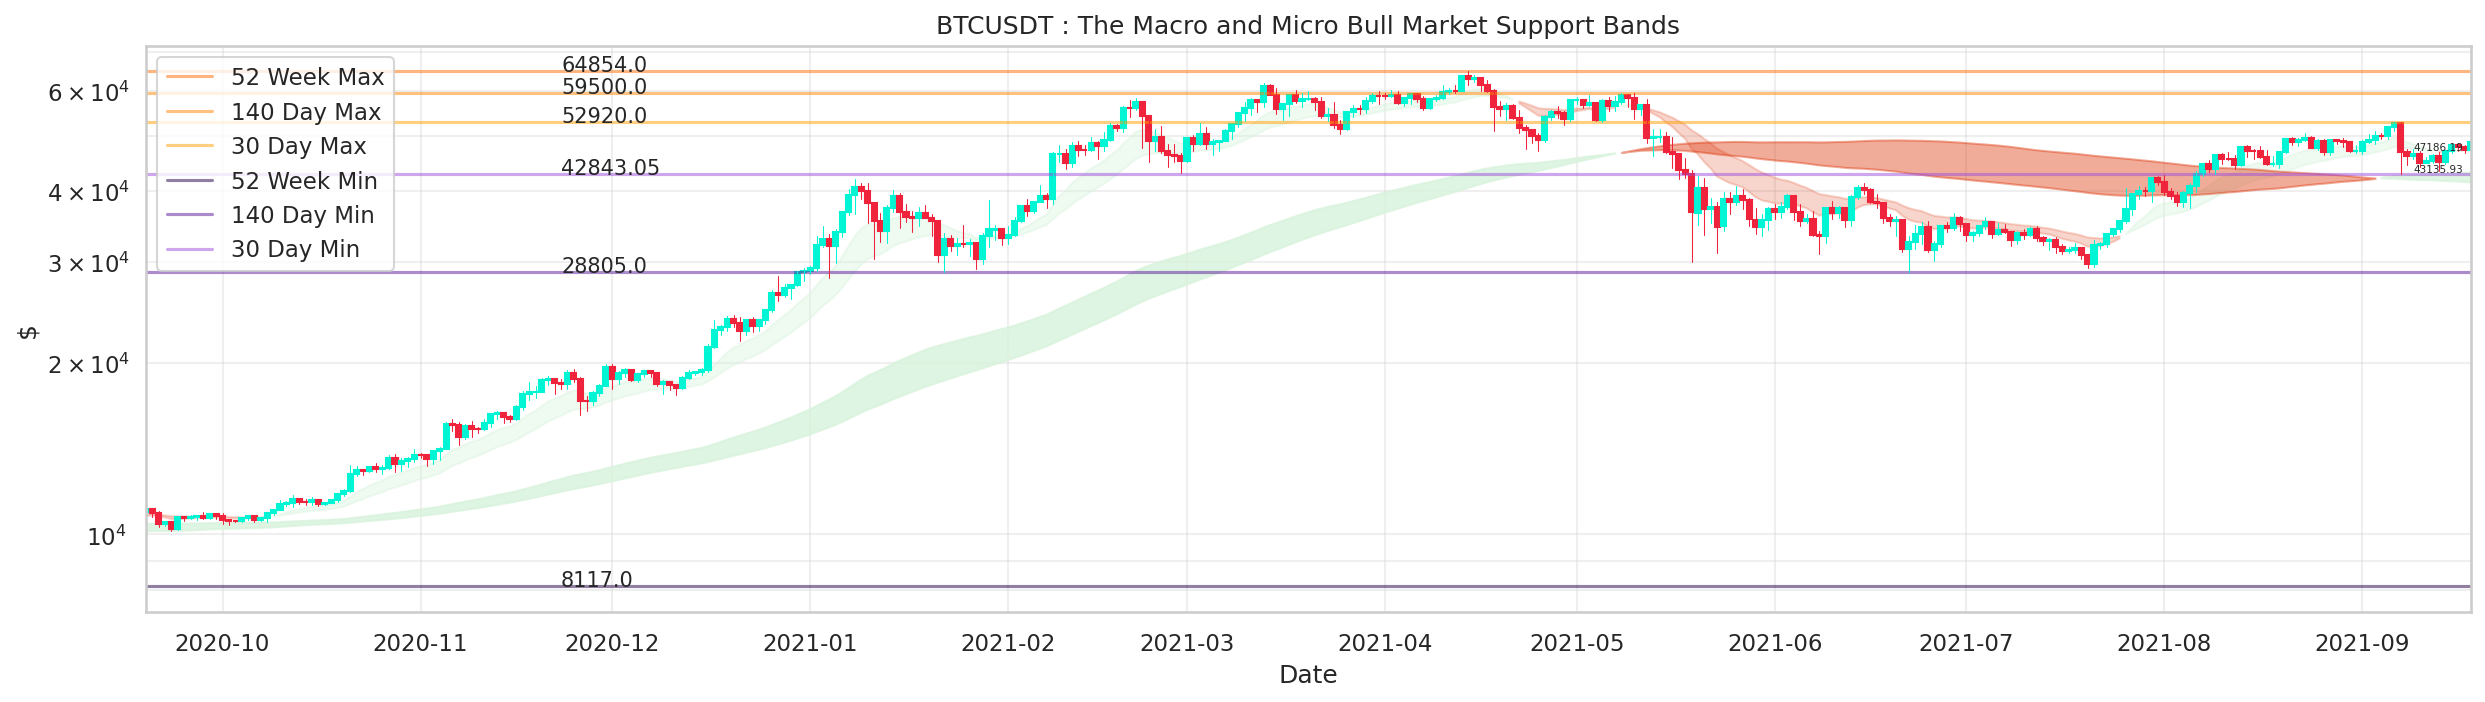

The MICRO support band shows ETHUSDT is BULLISH
ETHUSDT is 1.18% ABOVE the MICRO support: 3476.65
The MACRO support band shows ETHUSDT is BEARISH


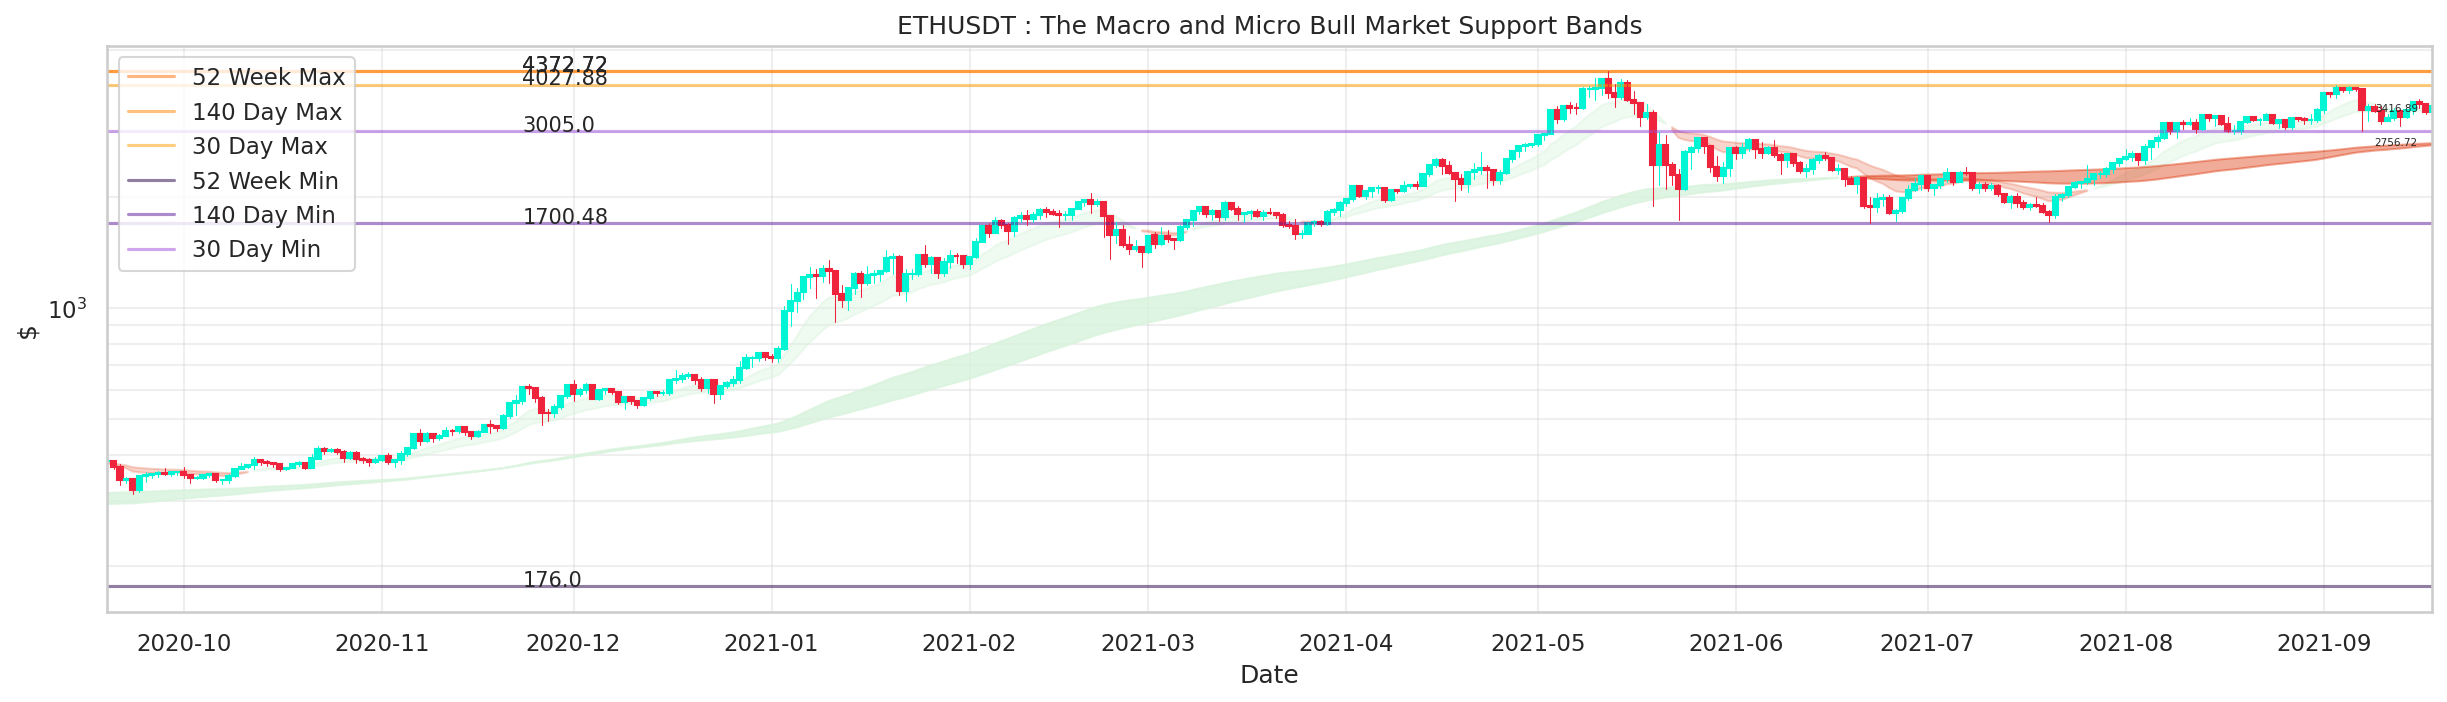

The MICRO support band shows SOLUSDT is BULLISH
SOLUSDT is 2.24% ABOVE the MICRO support: 157.74
The MACRO support band shows SOLUSDT is BULLISH
SOLUSDT is 136.3% ABOVE the MACRO support: 68.25


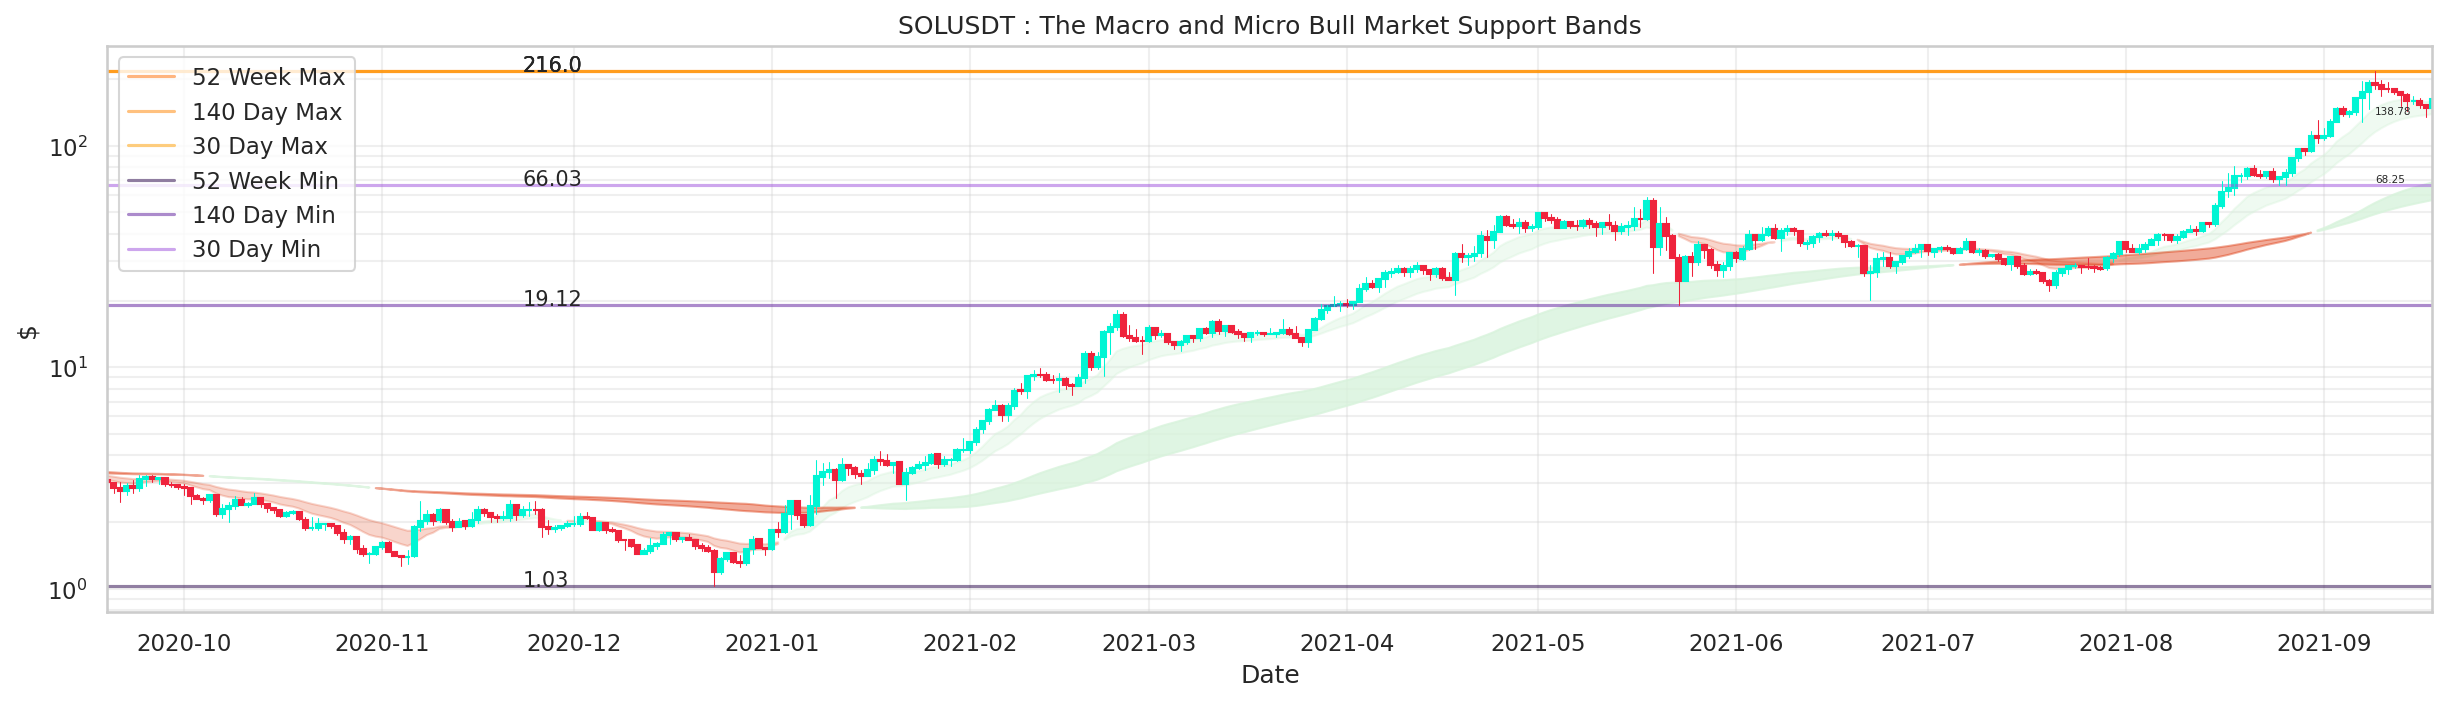

In [3]:
#hide_input
# _notebooks/2021-08-15-Macro-and-Micro-Bull-Market-Support-Bands.ipynb
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
pd.options.mode.chained_assignment = None
for tick in ['BTCUSDT','ETHUSDT','SOLUSDT']:
  # Bull Market Support 
  price, cp = price_data(tick,500, d='Binance')
  bullMarketSupport(price,cp,tick)
